In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import random as rd
import numpy as np
from openap import FlightPhase

In /home/alexis/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/alexis/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/alexis/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/alexis/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/alexis/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

## Visualisation de fichiers tirés aléatoirement dans la base de données

e490ee_TAM3527.csv=>trou temporel maximal: 30.0
89625a_ETD8010.csv=>trou temporel maximal: 30.0
780b3b_CES5269.csv=>trou temporel maximal: 40.0
8a061d_CTV812.csv=>trou temporel maximal: 1840.0
400eff_EZY132C.csv=>trou temporel maximal: 80.0
a68e7c_AAL1585.csv=>trou temporel maximal: 300.0
a6d9c3_AAL311.csv=>trou temporel maximal: 4780.0
adb0b4_AAL2583.csv=>trou temporel maximal: 70.0
0d08eb_VOI412.csv=>trou temporel maximal: 30.0
780d5f_UEA2208.csv=>trou temporel maximal: 110.0
a84660_NKS626.csv=>trou temporel maximal: 9190.0
adda24_AAL1028.csv=>trou temporel maximal: 20260.0
e490f1_TAM3299.csv=>trou temporel maximal: 231.0
781050_LKE9695.csv=>trou temporel maximal: 29.0
8a061c_CTV967.csv=>trou temporel maximal: 2470.0
aa15cc_AAL1310.csv=>trou temporel maximal: 120.0
4008b2_SHT9J.csv=>trou temporel maximal: 80.0
800b0a_IAD709.csv=>trou temporel maximal: 168799.0
e490f1_TAM3218.csv=>trou temporel maximal: 929.0
7805d1_.csv=>trou temporel maximal: 376080.0


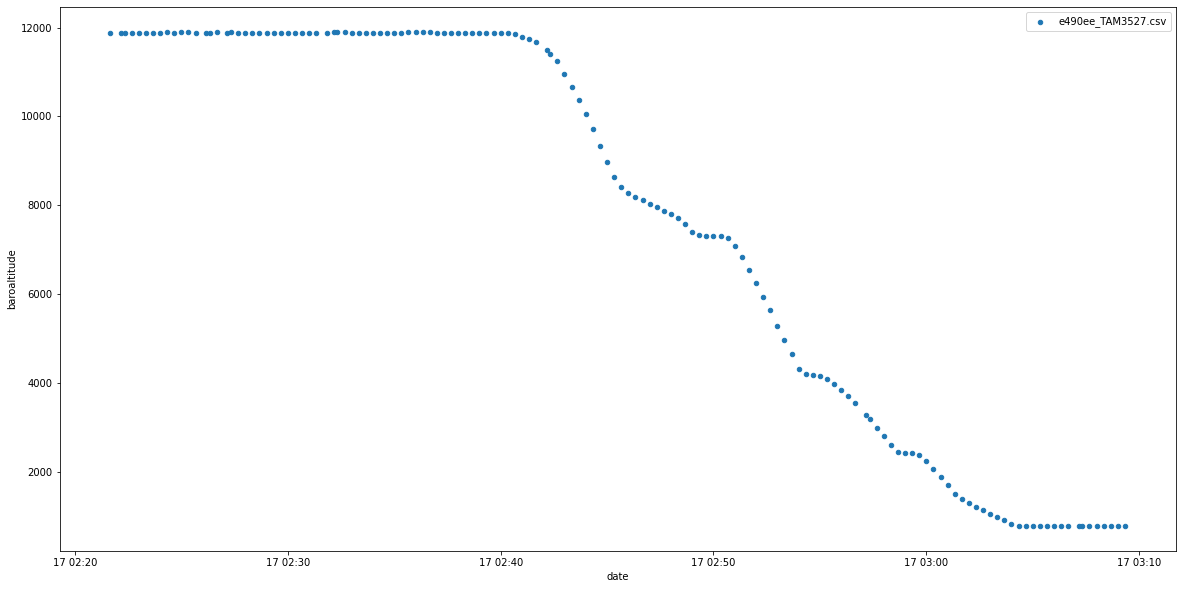

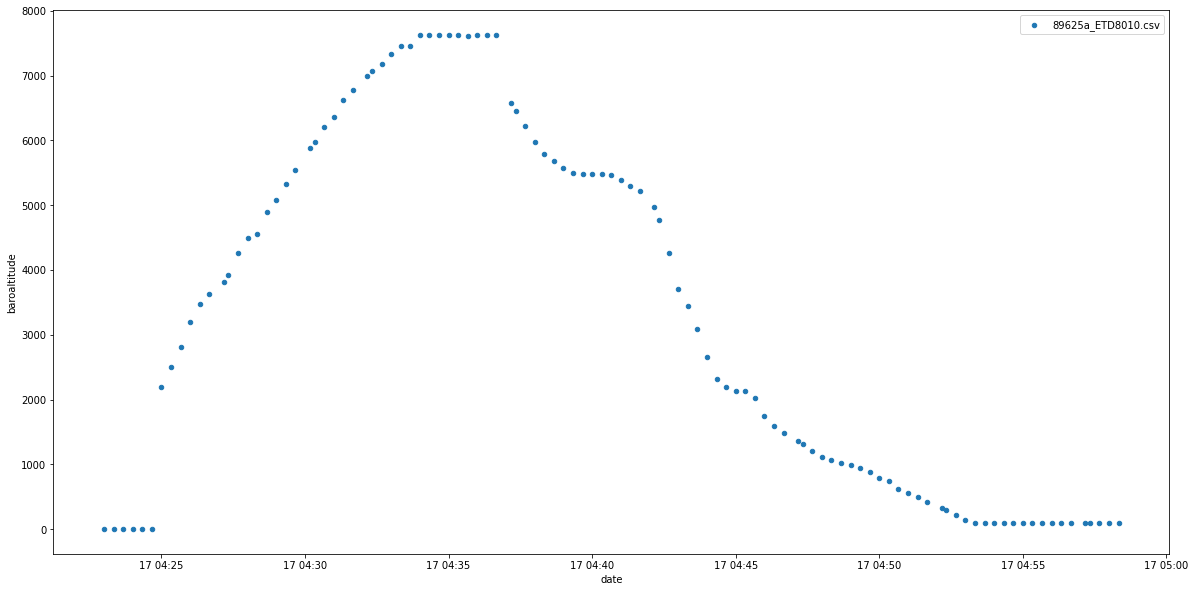

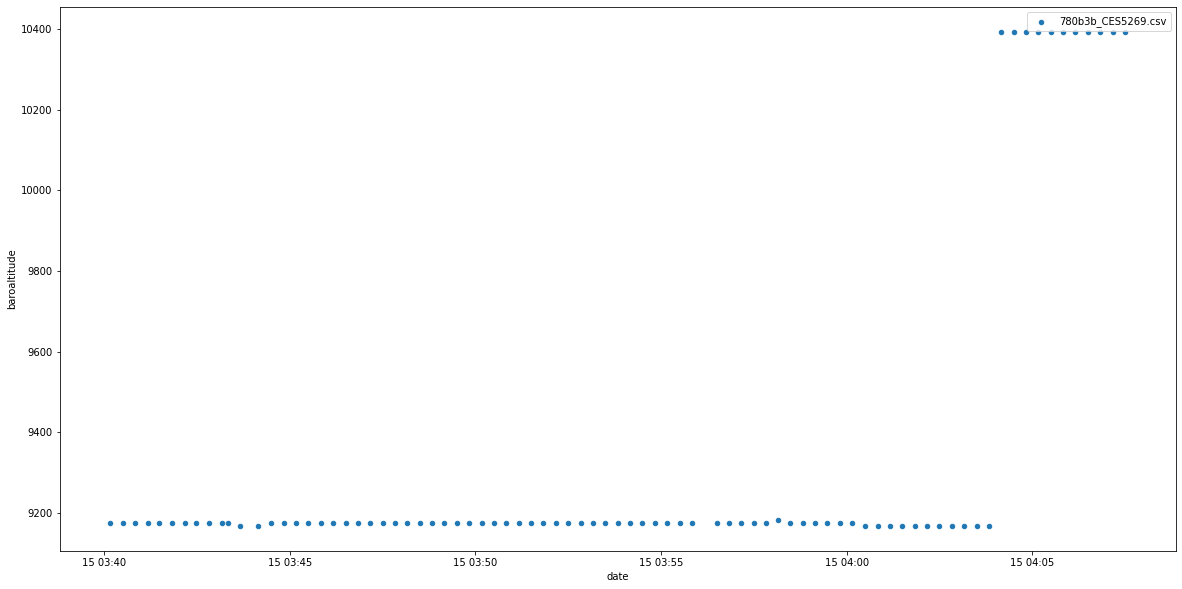

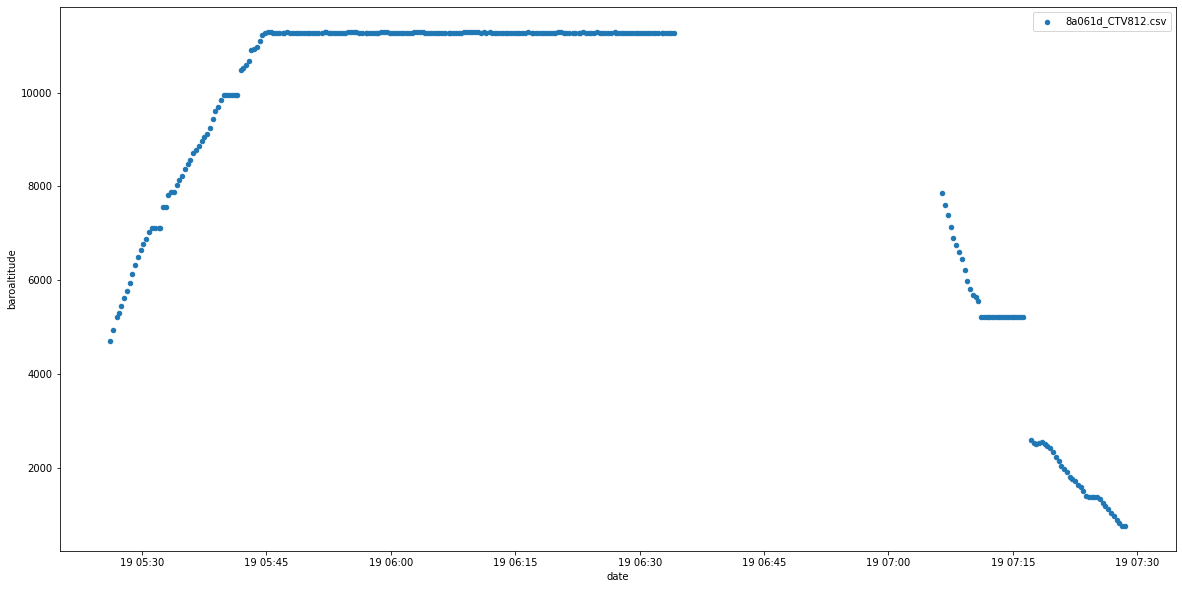

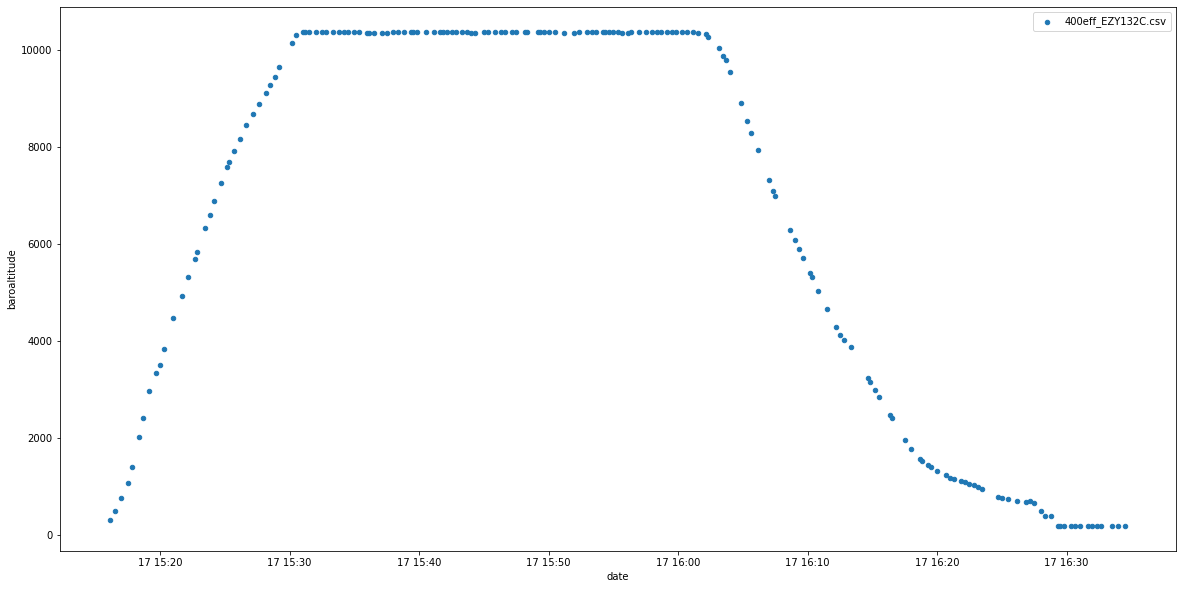

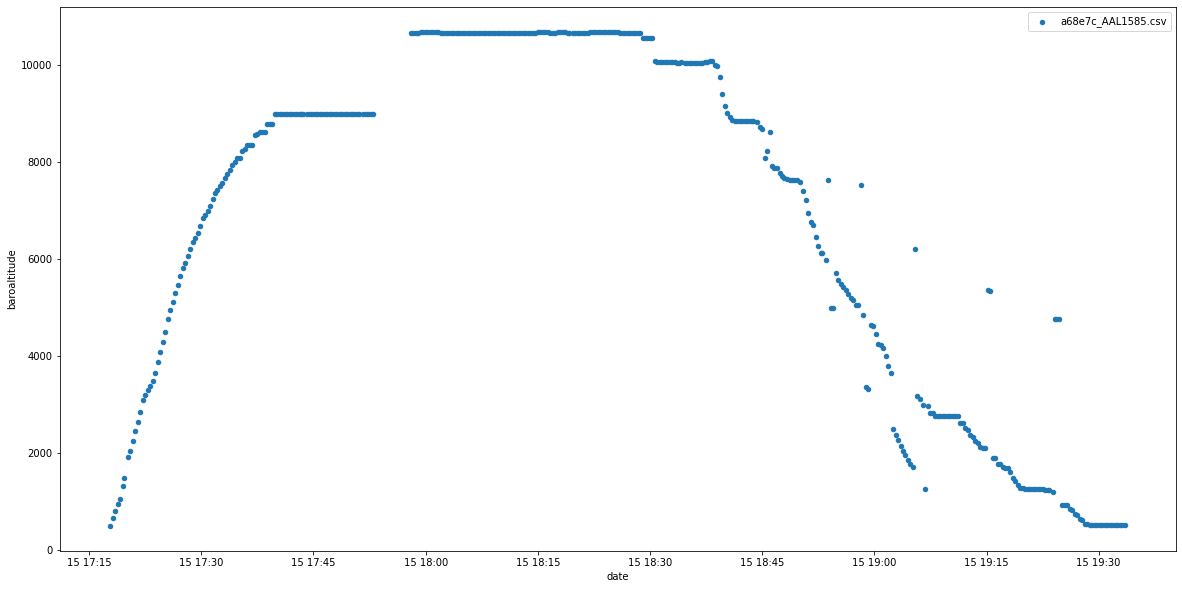

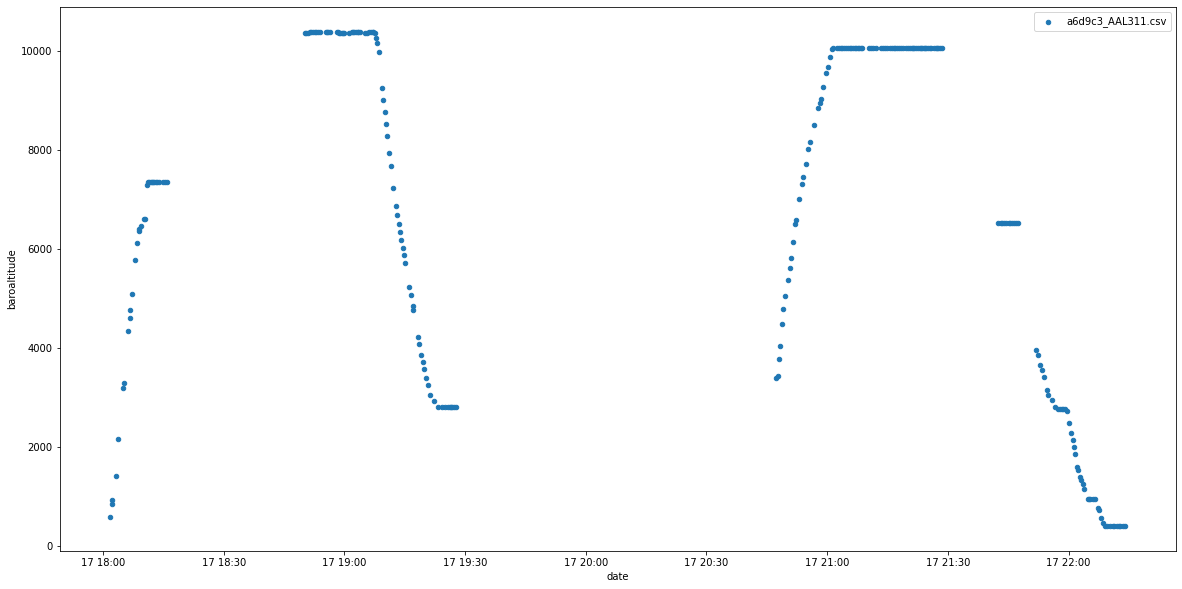

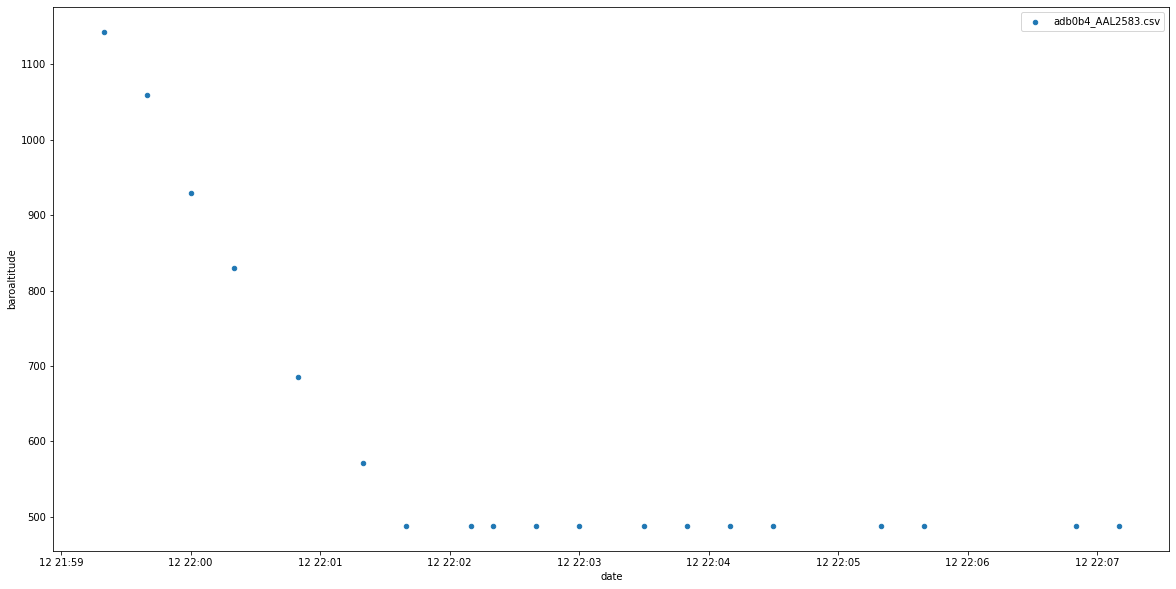

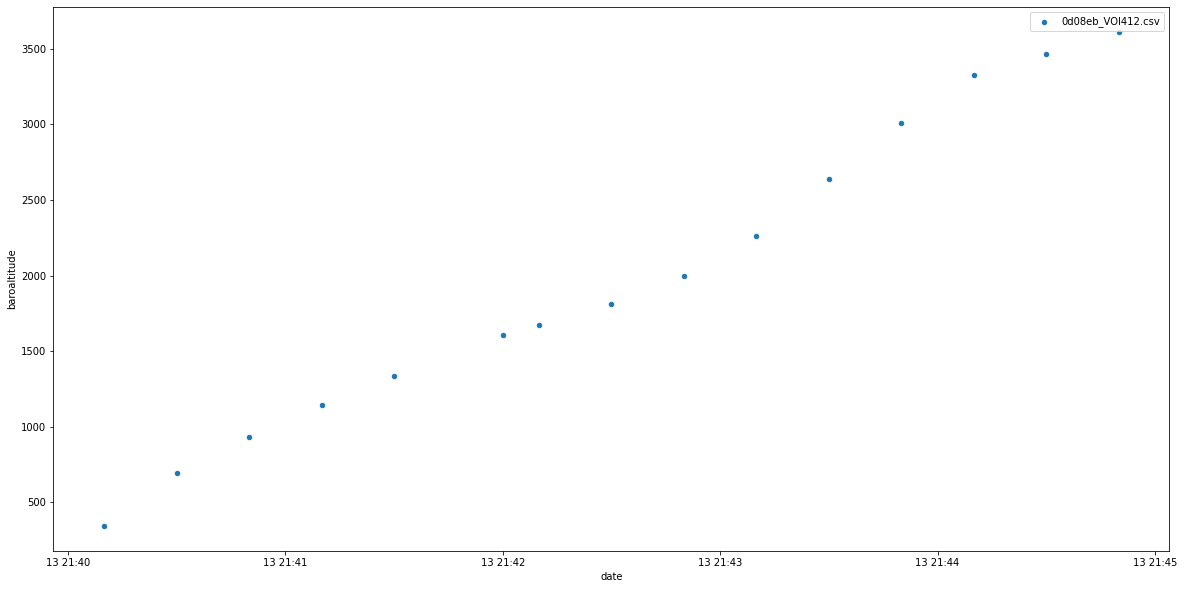

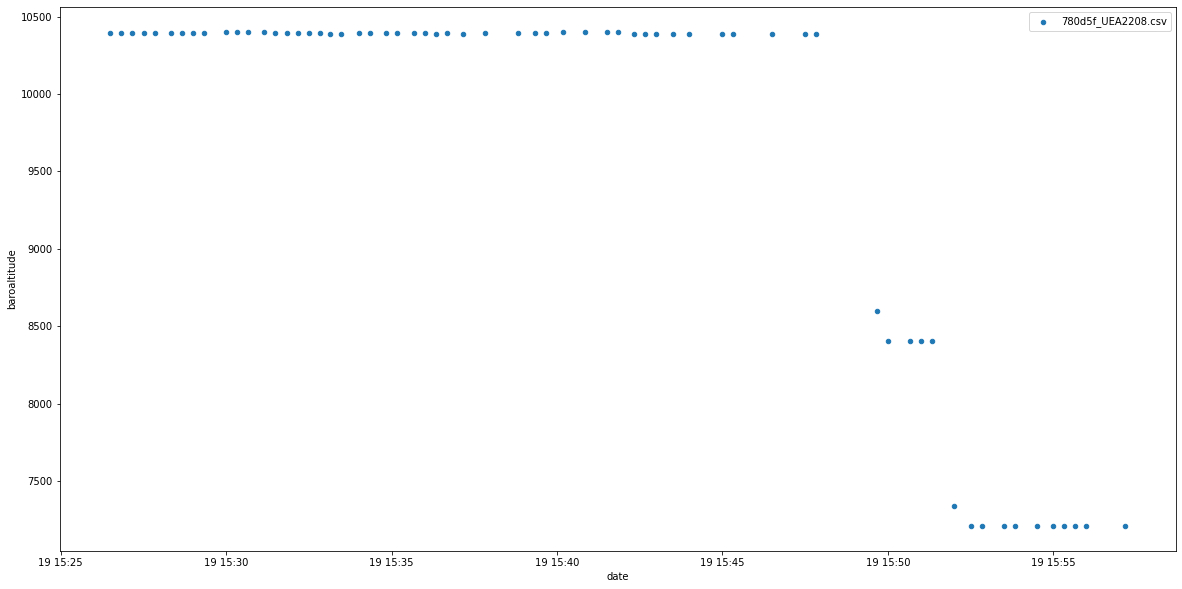

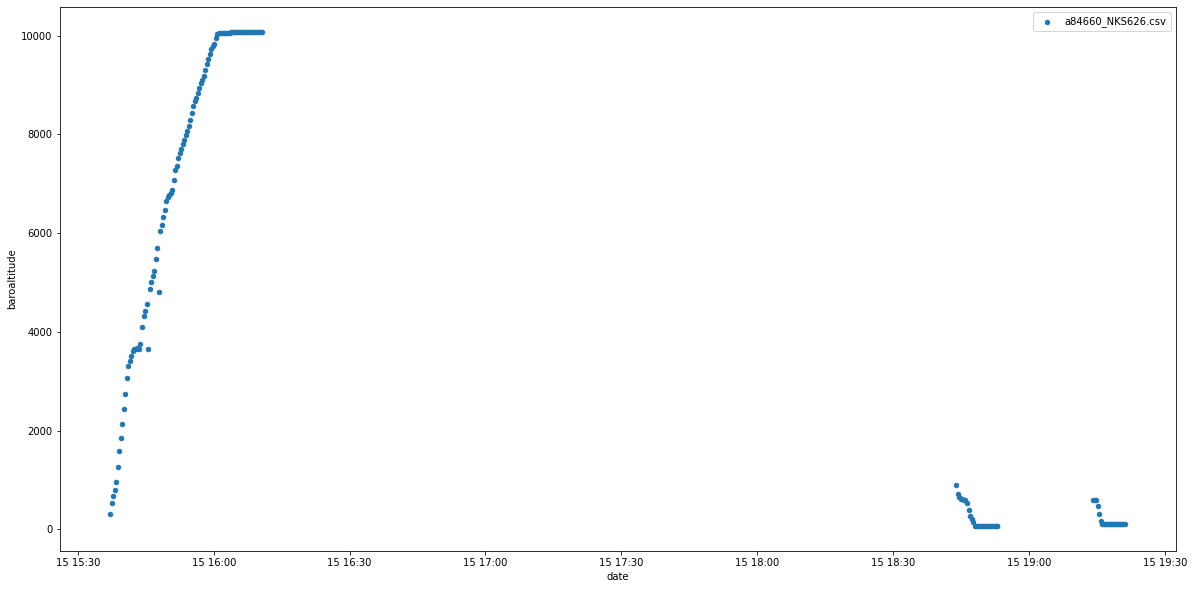

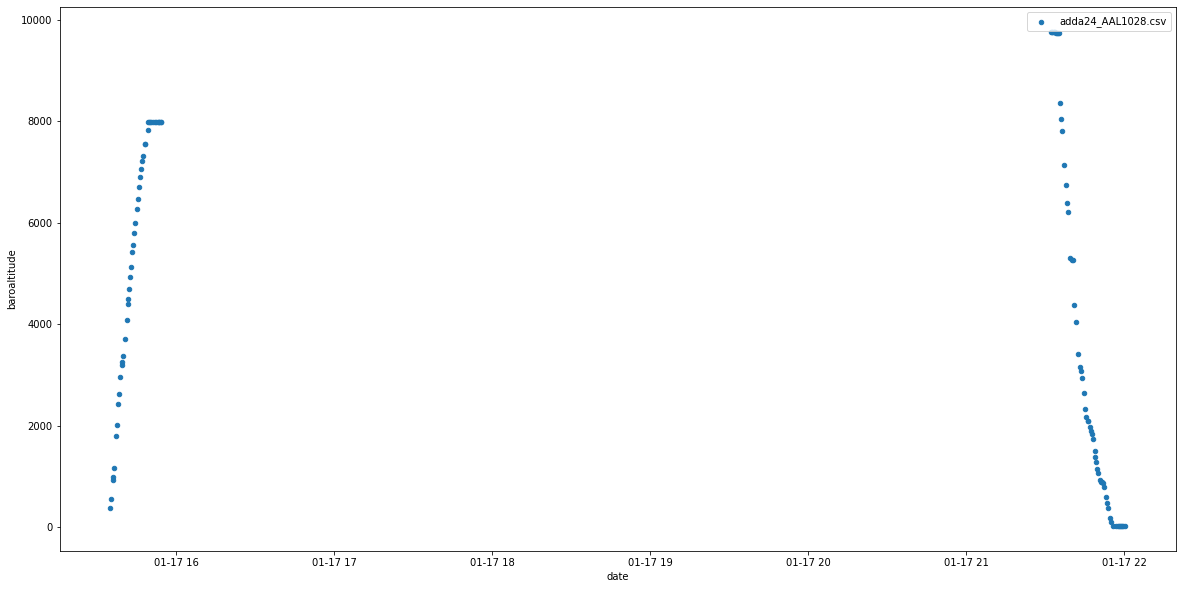

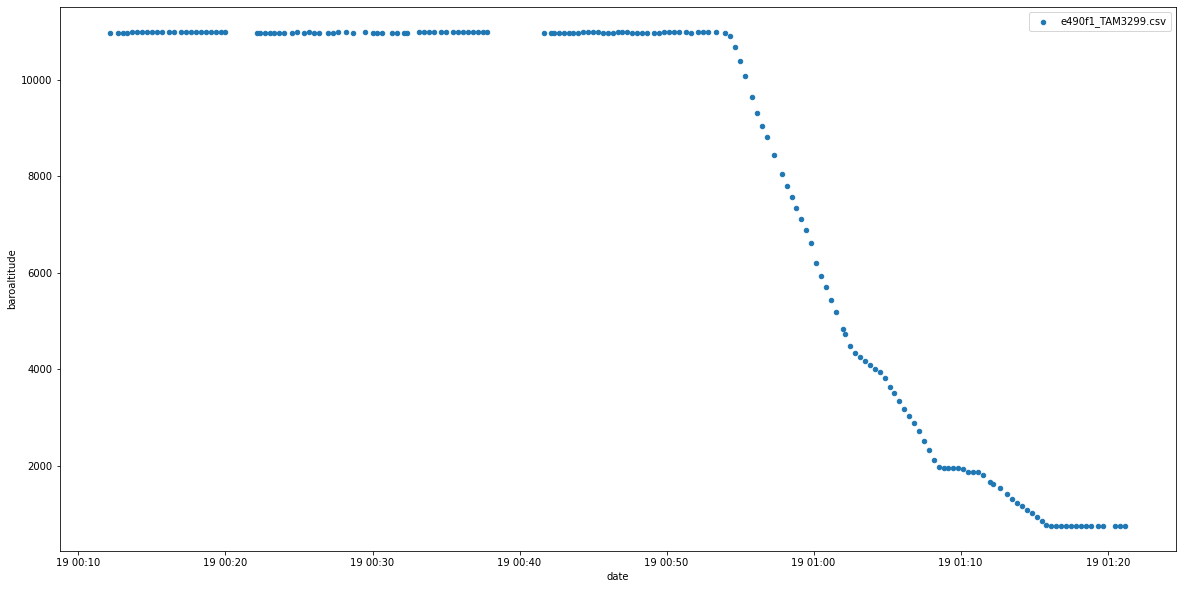

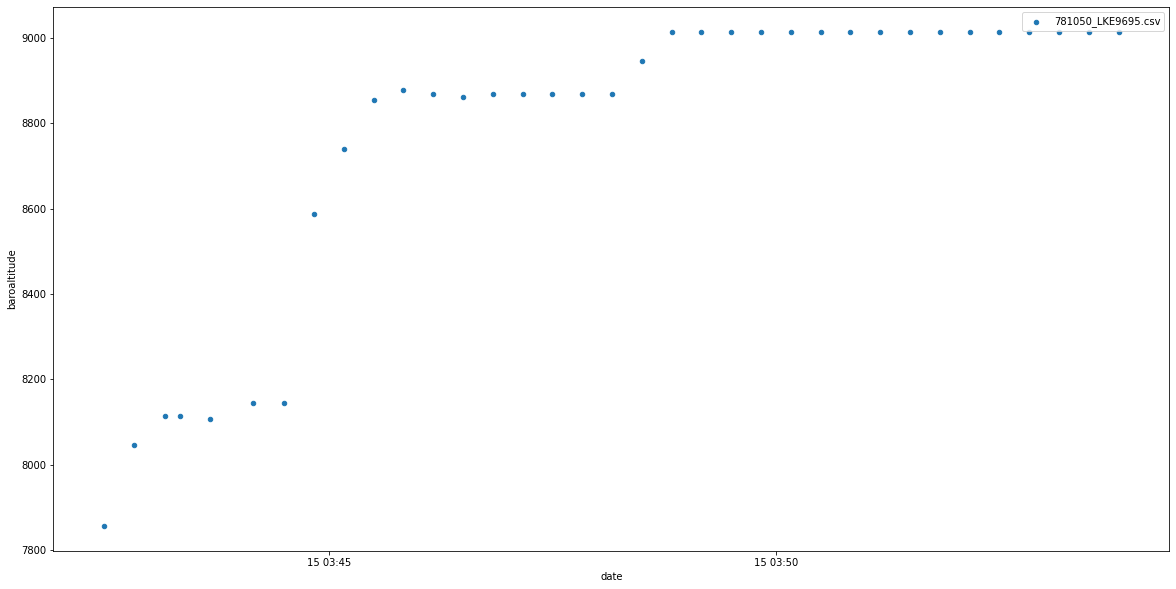

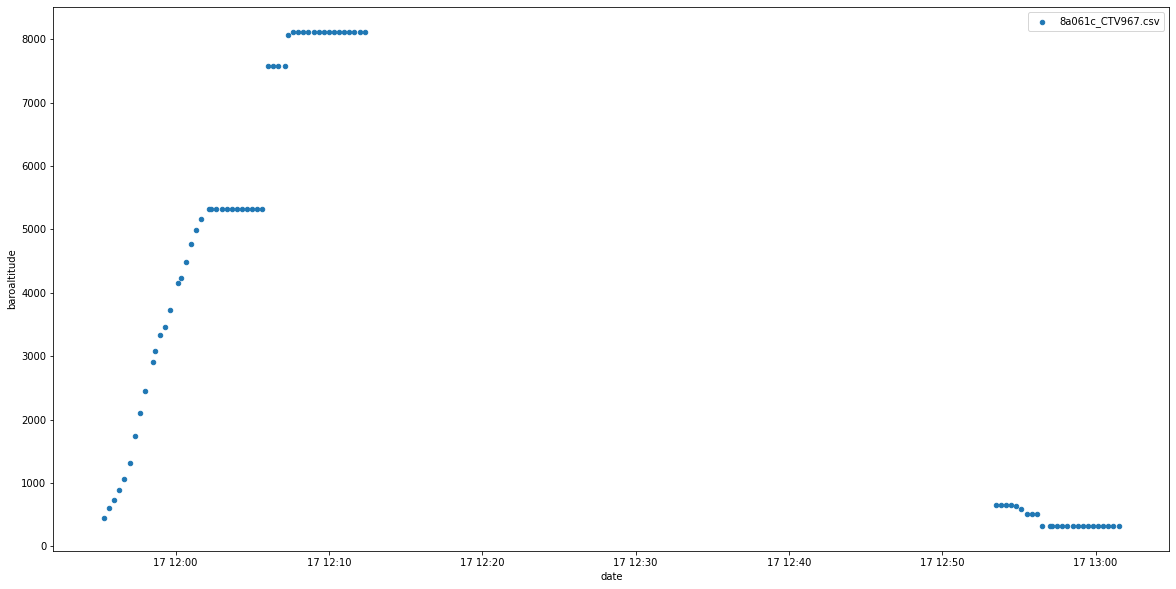

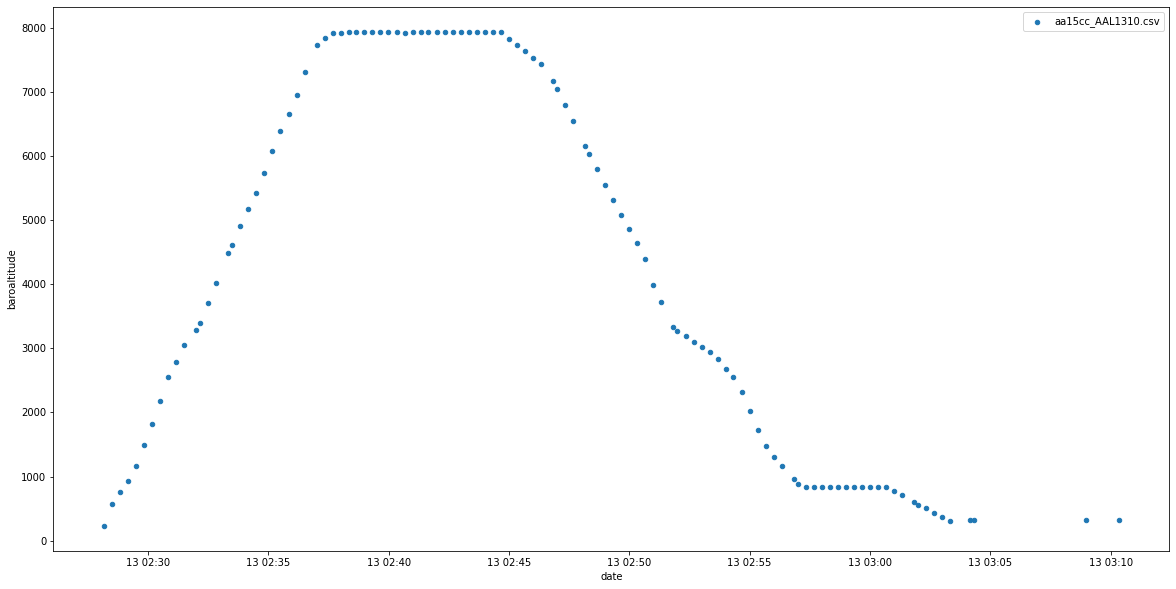

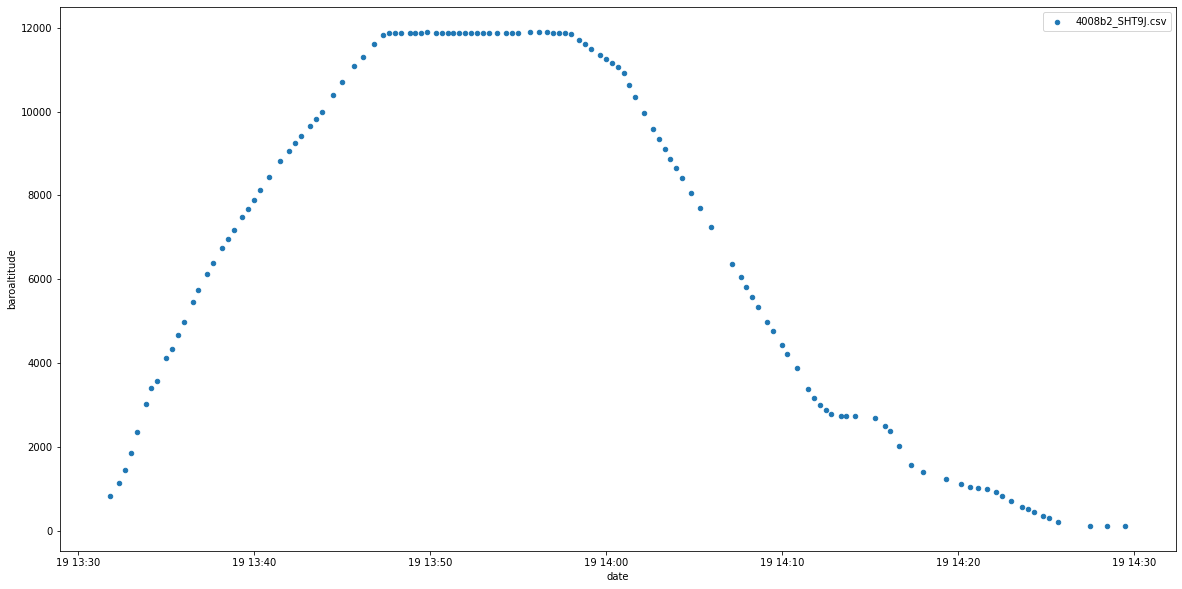

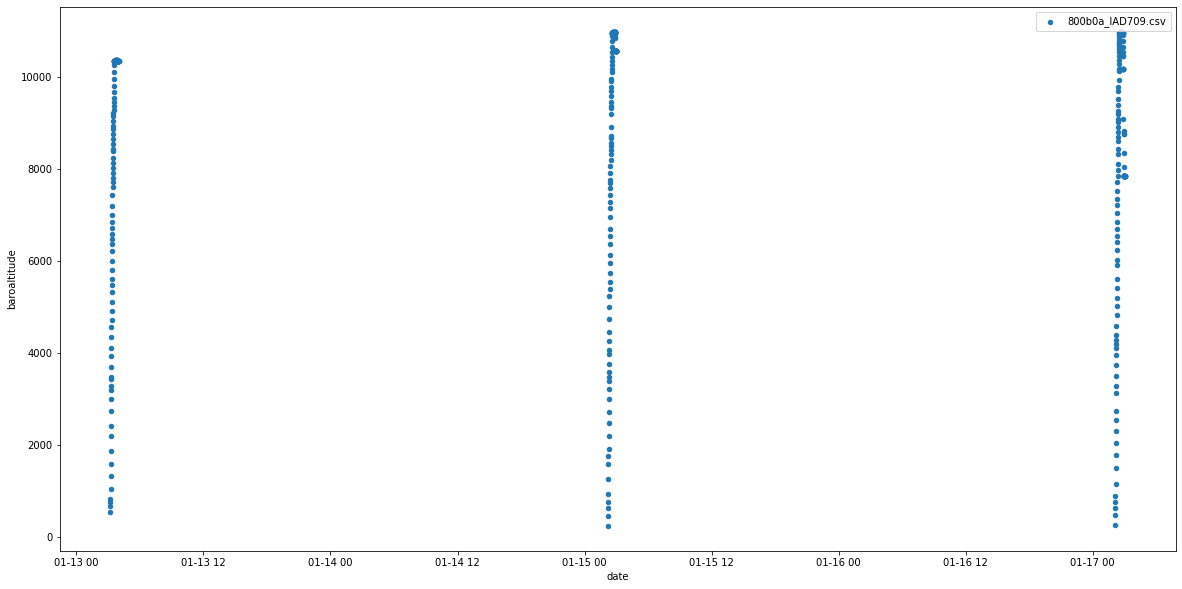

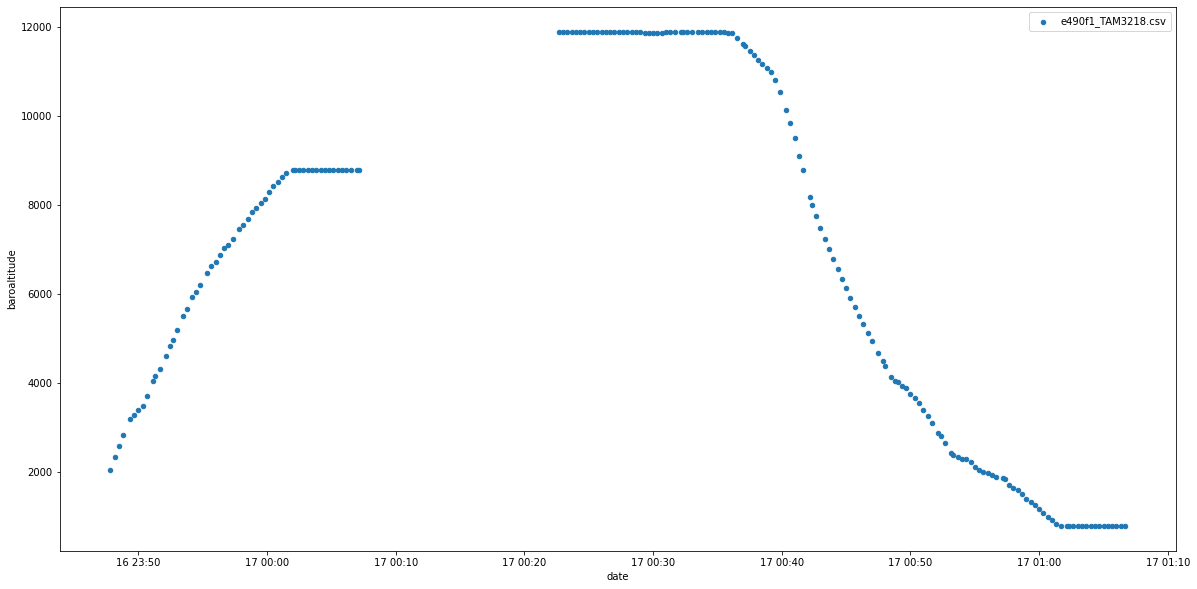

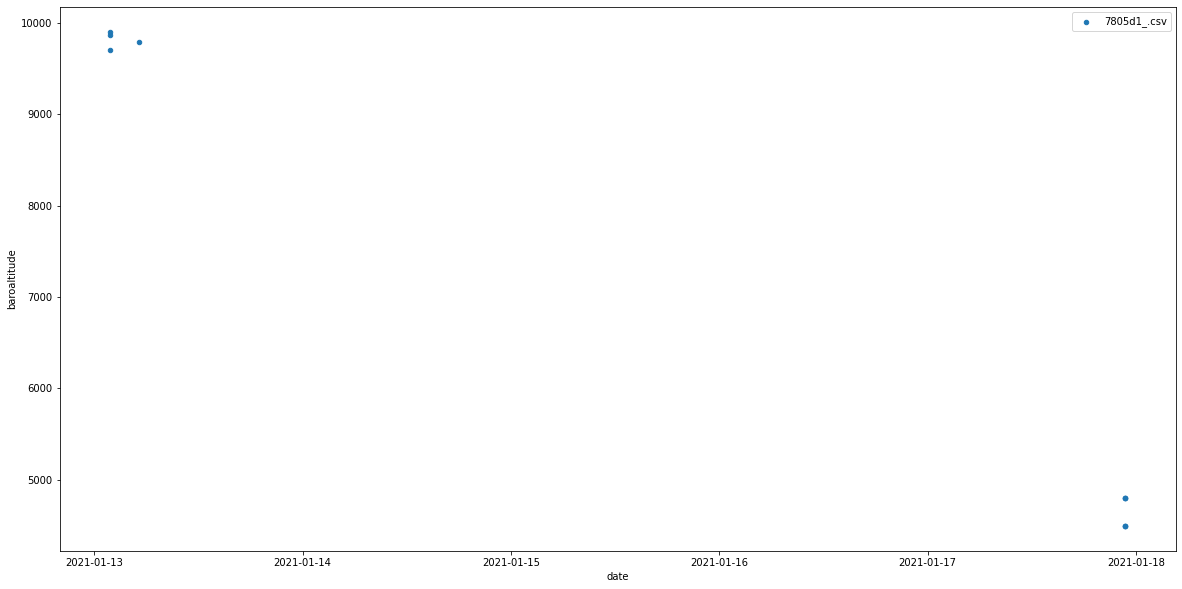

In [58]:
plt.rcParams["figure.figsize"]=20,10
# nombre de fichiers a visualiser
n = 20
# chemin vers la base de données
path_to_dataset = "../../__tempo/"

list_file_name = os.listdir(path_to_dataset)

# tirage des fichiers
file_to_analyse = rd.choices(list_file_name, k=n)

# affichage de l'altitude en fonction du temps pour le fichiers choisis
# calcul de la densité de points
for f in file_to_analyse:
    df = pd.read_csv(path_to_dataset+f, na_values='None')
    max_hole = df['time'].diff().max()
    df['date'] = pd.to_datetime(df['time'], unit='s')
    df.plot('date', 'baroaltitude', kind='scatter', label=f)
    print(f+"=>trou temporel maximal:", max_hole)
    

In [59]:
# proportion de fichiers traitable
acceptable_file = 5
nb_phase_flight = 9
print("proportion de fichiers traitables:", acceptable_file/n*100, "%")
print("estimation du nombre de données totales traitables:", acceptable_file/n*len(list_file_name))
print("estimation du nombre de phase moyennes par vol:", nb_phase_flight/acceptable_file)

proportion de fichiers traitables: 25.0 %
estimation du nombre de données totales traitables: 7769.25
estimation du nombre de phase moyennes par vol: 1.8


On remarque la plupart des vols ne sont pas complets. Beaucoup de vols comportent des "trous", ne comportent pas suffisament de points ou ne comportent qu'une partie des phases de vols.

Les descripteurs que nous calculons le sont pour des phases de vols complètes. Il convient donc de ne traiter uniquement les vols ayant au moins une phase de vol complète. Les autres données peuvent être supprimés.

Afin de détecter les vols ayant au moins une phase de vol complète, nous mettons en place une succession de règles que doivent vérifier les données. Ces règles sont les suivantes:
- pour chaque phase:
    - le trou temporel maximal n'est pas trop grand
    - le nombre de point permet la terminaison de l'algo
    - le début et la fin de la phase sont présentes

## Test de l'algorithme de selection sur les données choisies au hasard

In [72]:
def split_flights(df):
    diff = df['time'].diff()>=3600
    index = diff[diff==True].index
    
    flights = []
    first=0
    for i in index:
        flights.append(df.iloc[first:i].reset_index())
        first = i
    flights.append(df.iloc[first:])
    return flights


def enough_data(df):
    min_data = 40 #(une montee avec 2 points par minutes)
    df = df.copy()
    df.dropna(subset=['baroaltitude'], inplace=True)
    if len(df)<=min_data:
        return False
    return True

def check_and_drop_phase(df):
    # calcul nombre de points par phase
    nb_point_cl = len(df[df['phase']=='CL'])
    nb_point_cr = len(df[df['phase']=='CR'])
    nb_point_de = len(df[df['phase']=='DE'])
    
    # calcul présence de phase
    de = (len(df[df['phase']=='DE'])>=10)
    cr = (len(df[df['phase']=='CR'])>=10)
    cl = (len(df[df['phase']=='CL'])>=10)
    
    # calcul des trous max par phase
    hole_cl = df[df['phase']=='CL']['time'].diff().max()
    hole_cr = df[df['phase']=='CR']['time'].diff().max()
    hole_de = df[df['phase']=='DE']['time'].diff().max()
    
    #phase climb
    if cl:
        is_begin_cl = (df['baroaltitude'].iloc[0:10].min() <= 2000)
        if (hole_cl>=240) or not(is_begin_cl) or not(cr):
            df.drop(labels=df[df['phase']=='CL'].index, inplace=True)
    else:
        df.drop(labels=df[df['phase']=='CL'].index, inplace=True)
    
    # phase croisiere
    if (hole_cr>=1080) or not(cl) or not(de) or not(cr):
        df.drop(labels=df[df['phase']=='CR'].index, inplace=True)

    #phase descent
    if de:
        is_end_de = (df['baroaltitude'].iloc[len(df)-10:].min() <= 2000)
        if (hole_de>=240) or not(is_end_de) or not(cr):
            df.drop(labels=df[df['phase']=='DE'].index, inplace=True)
    else:
        df.drop(labels=df[df['phase']=='DE'].index, inplace=True)
        
    return df[(df['phase']=='CL') | (df['phase']=='CR') | (df['phase']=='DE')]

In [75]:
import warnings
warnings.filterwarnings('ignore')

m_to_ft = 3.28084
m_by_s_to_ft_by_min = 3.28084*60
m_by_s_to_kt = 1.94384

result = []
name=[]
for f in file_to_analyse:
    df = pd.read_csv(path_to_dataset+f, na_values='None')

    df.dropna(subset=['baroaltitude',], inplace=True)
    df.reset_index(inplace=True)
    list_flight = split_flights(df)
    j=0
    for flight in list_flight:
        j+=1
        if enough_data(flight):
            
            flight['time_bis']= flight['time'] - flight['time'].iloc[0]
            phase_slicer = FlightPhase()
            phase_slicer.set_trajectory(flight['time_bis'].values,flight['baroaltitude'].values*m_to_ft,flight['velocity'].values*m_by_s_to_kt, flight['vertrate'].values*m_by_s_to_ft_by_min)

            flight['phase'] = phase_slicer.phaselabel()
            flight.drop(columns='time_bis', inplace=True)
            
            flight = check_and_drop_phase(flight)
            if len(flight)>0:
                result.append(flight)
                name.append(f)

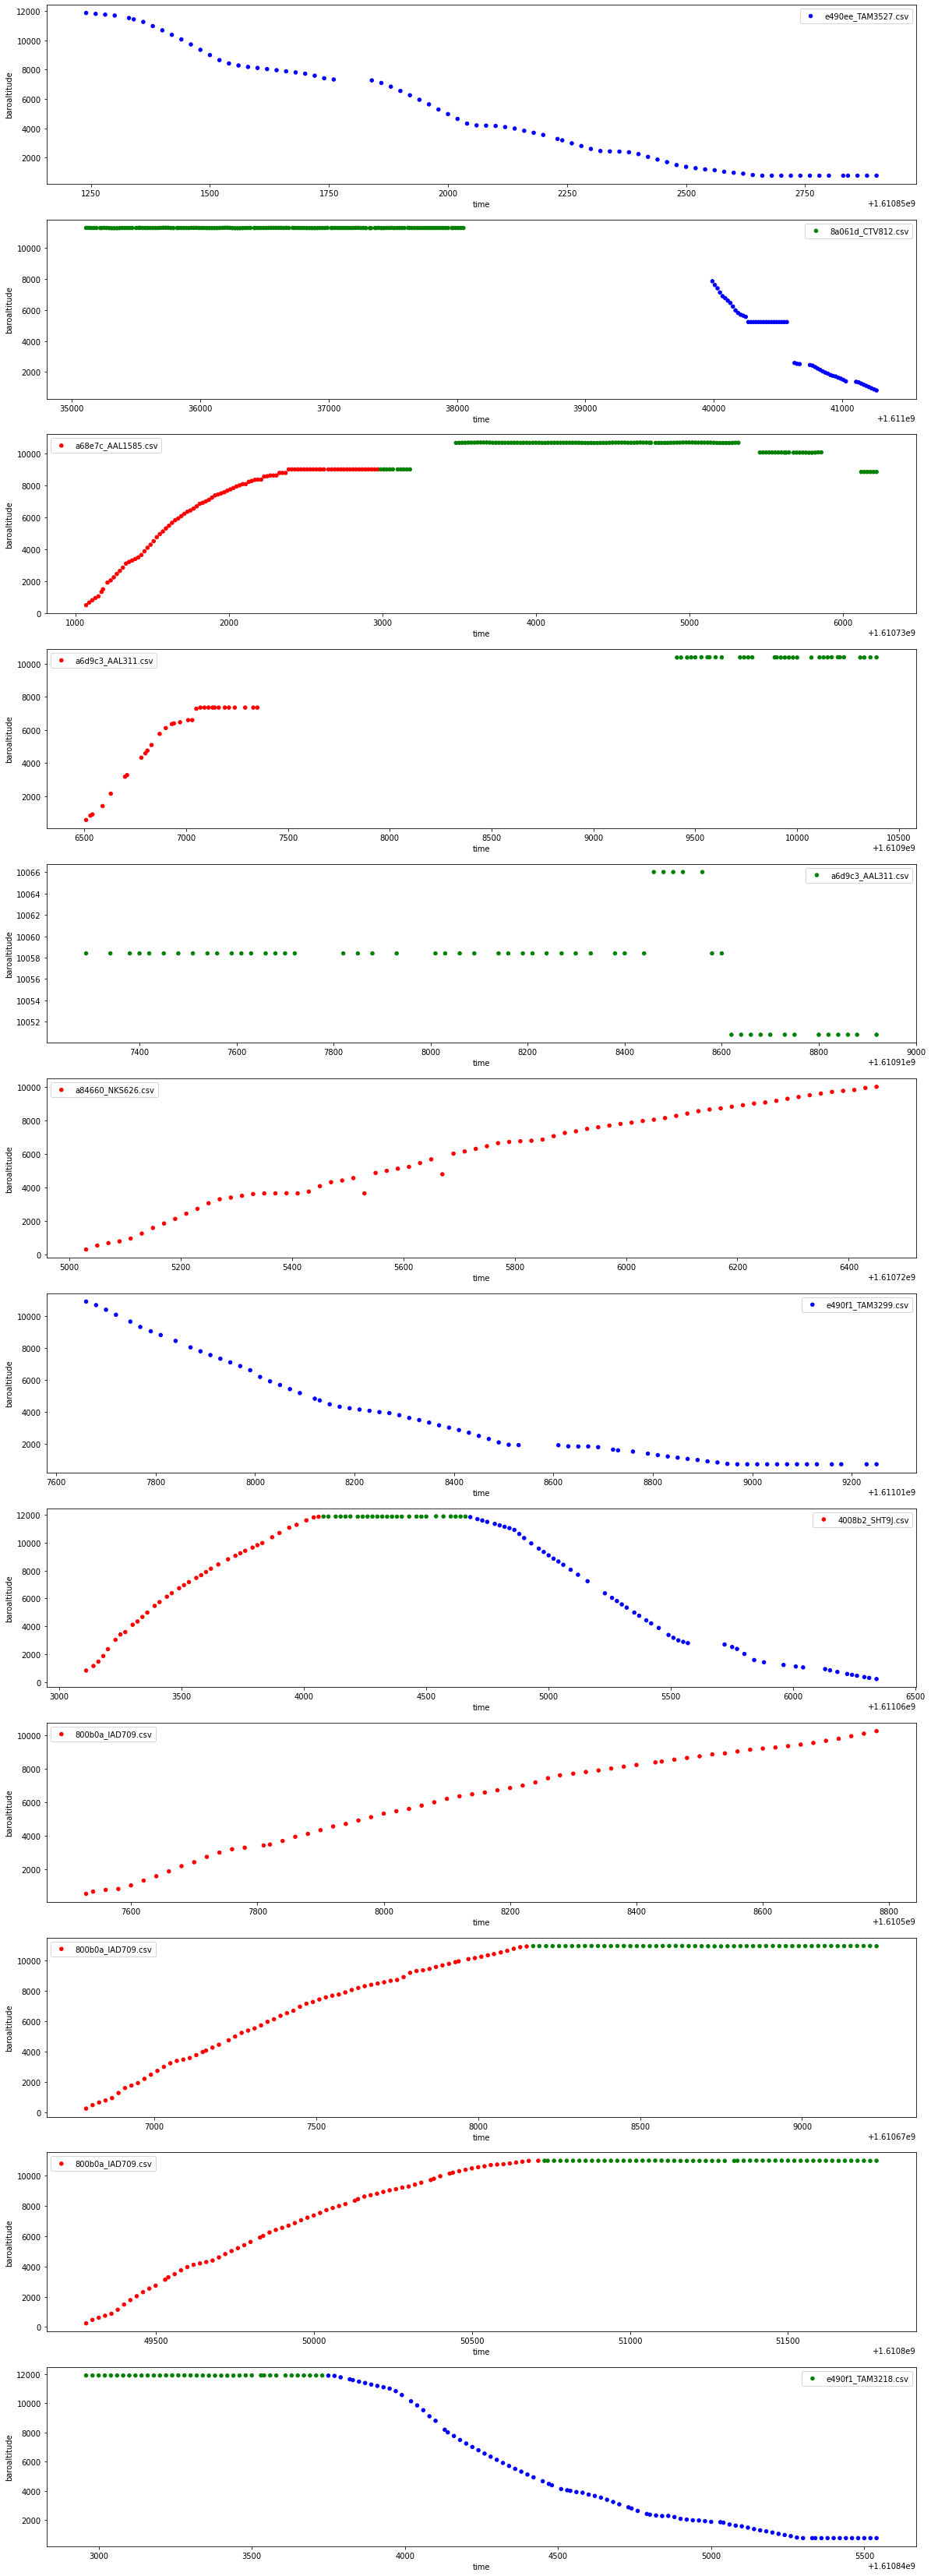

In [76]:
plt.rcParams["figure.figsize"]=20,60

colormap = {
    'CL':'red',
    'CR':'green',
    'DE':'blue',
    'LVL':'grey',
    'GND':'grey',
    np.nan:'grey'
}

nb_row=len(result)
i=0
for df in result:
    df['color']=[colormap[x] for x in df['phase'].values]
    ax=plt.subplot(nb_row,1,i+1)
    df.plot.scatter('time', 'baroaltitude', c='color', ax=ax, label=name[i])
    i+=1